<a href="https://colab.research.google.com/github/geoffwoollard/learn_cryoem_math/blob/master/nb/3DCNN_sspred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal
Demo 3D CNN for secondary structure prediction
a la Haruspex from Andrea Thorn's group

# Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
!pip install mrcfile
import mrcfile


     |████████████████████████████████| 51kB 6.0MB/s 


In [ ]:
!pip install biopandas  
#!pip install biopython
!pip install DSSPparser
from DSSPparser import parseDSSP
from biopandas.pdb import PandasPdb


In [4]:
import os
import numpy as np
import pandas as pd
from numba import jit
import matplotlib.pyplot as plt
def doplt(arr2d,cmap='gray'):
  if cmap is None:
    plt.imshow(arr2d)
  else:
    plt.imshow(arr2d,cmap=cmap)

## GPU

In [5]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2127810192974182286
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 17878963939406706440
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 4587370116517490665
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15473775744
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9520480524764045530
physical_device_desc: "device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:04.0, compute capability: 7.0"
]


# Data
|notes|EMD|PDB|
|-|-|-|
|IP3R, Ca2+ bound by R. Hite|EMD-7988|6DR2|
|TRPV1 from the [2016 map challenge](https://challenges.emdataresource.org/?q=map-challenge-targets)|EMD-5778|3j5p|


In [ ]:
EMDB = '5778' #@param {type:"string"}
Filename = "emd_"+EMDB+".map.gz"
ftp_string = "ftp://ftp.ebi.ac.uk/pub/databases/emdb/structures/EMD-"+EMDB+"/map/emd_"+EMDB+".map.gz"
!wget $ftp_string

--2020-11-12 07:26:05--  ftp://ftp.ebi.ac.uk/pub/databases/emdb/structures/EMD-5778/map/emd_5778.map.gz
           => ‘emd_5778.map.gz.2’
Resolving ftp.ebi.ac.uk (ftp.ebi.ac.uk)... 193.62.197.74
Connecting to ftp.ebi.ac.uk (ftp.ebi.ac.uk)|193.62.197.74|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /pub/databases/emdb/structures/EMD-5778/map ... done.
==> SIZE emd_5778.map.gz ... 48375630
==> PASV ... done.    ==> RETR emd_5778.map.gz ... done.
Length: 48375630 (46M) (unauthoritative)

emd_5778.map.gz.2   100%[===================>]  46.13M  9.02MB/s    in 5.6s    

2020-11-12 07:26:14 (8.21 MB/s) - ‘emd_5778.map.gz.2’ saved [48375630]



In [ ]:
pdbid = '3j5p' #@param {type:"string"}
pdb_fname = pdbid+".pdb"
cif_fname = pdbid+".cif"
string = "https://files.rcsb.org/download/"+pdb_fname
!wget $string
string = "https://files.rcsb.org/download/"+cif_fname
!wget $string

--2020-11-12 07:26:14--  https://files.rcsb.org/download/3j5p.pdb
Resolving files.rcsb.org (files.rcsb.org)... 132.249.210.142
Connecting to files.rcsb.org (files.rcsb.org)|132.249.210.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘3j5p.pdb.2’

3j5p.pdb.2              [    <=>             ]   1.50M  1.92MB/s    in 0.8s    

2020-11-12 07:26:16 (1.92 MB/s) - ‘3j5p.pdb.2’ saved [1578771]

--2020-11-12 07:26:16--  https://files.rcsb.org/download/3j5p.cif
Resolving files.rcsb.org (files.rcsb.org)... 132.249.210.142
Connecting to files.rcsb.org (files.rcsb.org)|132.249.210.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘3j5p.cif.2’

3j5p.cif.2              [    <=>             ]   1.71M  1.88MB/s    in 0.9s    

2020-11-12 07:26:17 (1.88 MB/s) - ‘3j5p.cif.2’ saved [1793565]



## read in model

## biopandas

In [ ]:
ppdb = PandasPdb().read_pdb(pdb_fname) #ppdb = PandasPdb().fetch_pdb('3j5p')
ppdb.df['ATOM']

,record_name,atom_number,blank_1,atom_name,alt_loc,residue_name,blank_2,chain_id,residue_number,insertion,blank_3,x_coord,y_coord,z_coord,occupancy,b_factor,blank_4,segment_id,element_symbol,charge,line_idx
0,ATOM,1,,N,,LEU,,B,111,,,-22.437,63.276,48.231,1.0,38.59,,,N,NaN,849
1,ATOM,2,,CA,,LEU,,B,111,,,-22.866,63.139,46.796,1.0,38.96,,,C,NaN,850
2,ATOM,3,,C,,LEU,,B,111,,,-22.155,62.012,46.022,1.0,39.03,,,C,NaN,851
3,ATOM,4,,O,,LEU,,B,111,,,-21.022,61.639,46.348,1.0,38.95,,,O,NaN,852
4,ATOM,5,,CB,,LEU,,B,111,,,-22.696,64.458,46.041,1.0,38.99,,,C,NaN,853
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18631,ATOM,18635,,N,,UNK,,D,762,,,-13.222,22.014,30.108,1.0,30.00,,,N,NaN,19483
18632,ATOM,18636,,CA,,UNK,,D,762,,,-13.972,22.862,31.027,1.0,30.00,,,C,NaN,19484
18633,ATOM,18637,,C,,UNK,,D,762,,,-15.346,22.274,31.335,1.0,30.00,,,C,NaN,19485
18634,ATOM,18638,,O,,UNK,,D,762,,,-15.701,22.081,32.499,1.0,30.00,,,O,NaN,19486


## make synthetic map

In [ ]:
df = ppdb.df['ATOM']
df.head()

,record_name,atom_number,blank_1,atom_name,alt_loc,residue_name,blank_2,chain_id,residue_number,insertion,blank_3,x_coord,y_coord,z_coord,occupancy,b_factor,blank_4,segment_id,element_symbol,charge,line_idx
0,ATOM,1,,N,,LEU,,B,111,,,-22.437,63.276,48.231,1.0,38.59,,,N,NaN,849
1,ATOM,2,,CA,,LEU,,B,111,,,-22.866,63.139,46.796,1.0,38.96,,,C,NaN,850
2,ATOM,3,,C,,LEU,,B,111,,,-22.155,62.012,46.022,1.0,39.03,,,C,NaN,851
3,ATOM,4,,O,,LEU,,B,111,,,-21.022,61.639,46.348,1.0,38.95,,,O,NaN,852
4,ATOM,5,,CB,,LEU,,B,111,,,-22.696,64.458,46.041,1.0,38.99,,,C,NaN,853


In [ ]:
@jit(nopython=True,parallel=False)
def make_synthetic_map(xyz_coords,r_min,pad,N,psize_A,s2):
  synthetic_map = np.zeros((N,N,N))
  for i in range(N):
    for j in range(N):
      for k in range(N):
        mu = psize_A*np.array([i,j,k]) + r_min - pad # convert from index to coords
        synthetic_map[i,j,k] = np.exp(-((xyz_coords - mu)**2/(2*s2)).sum(1)).sum()
  return(synthetic_map)


In [ ]:
rs = df[['x_coord','y_coord','z_coord']]
r_min =  rs.min().values
r_min_max = rs.max() - r_min

pad = 20 # in A
psize_A=1
N = int((np.ceil(r_min_max).max() + pad*2)/psize_A)
xyz_coords = df[['x_coord','y_coord','z_coord']].values

N

179

In [ ]:
%%time
s2=1
synthetic_map = make_synthetic_map(xyz_coords,r_min,pad,N,psize_A,s2)

CPU times: user 47min 37s, sys: 24.7 s, total: 48min 2s
Wall time: 47min 56s


## dssp

In [ ]:
parser = parseDSSP('/content/drive/My Drive/mbp/4hel.dssp')
parser.parse()
pddict = parser.dictTodataframe()
pddict.head(2)

,resnum,inscode,chain,aa,struct,structdetails,bp1,bp2,acc,h_nho1,h_ohn1,h_nho2,h_ohn2,tco,kappa,alpha,phi,psi,xca,yca,zca,rcsb_given_chain,author_given_chain
0,1,2,A,A,,,0,0,84,"0, 0.0","3215,-0.1","0, 0.0","3217,-0.1",0.000,360.0,360.0,360.0,155.7,-36.7,12.5,-72.2,A,A 1 2 0 0 ...
1,2,3,A,A,,-,0,0,21,"3215,-0.1","521,-1.2","1,-0.1","3215,-0.2",-0.251,360.0,-145.2,-56.0,134.3,-37.5,12.0,-68.5,A,A 2 3 0 0 ...


In [ ]:
pddict['struct'].value_counts()

  H    3705
  E    1262
        980
  T     689
  S     527
  G     123
  B      64
*        13
Name: struct, dtype: int64

## fill in with ss

In [ ]:
ss_map = np.zeros((N,N,N),dtype=np.int32)
ss_map.shape

In [ ]:
d={e:i+1 for i,e in enumerate(pddict['struct'].unique())}
pddict['struct_number'] = pddict['struct'].map(d)

In [ ]:
%%time
label_pad=0
for idx in range(pddict.shape[0]):
  row = pddict.iloc[idx]
  idx_true = (df['residue_number'] == int(row['resnum'])) & (df['chain_id'] == row['chain'])
  ijk_ss_map = np.int32(np.ceil((df[idx_true][['x_coord','y_coord','z_coord']].values - r_min + pad)/psize_A))
  #ss_map[ijk_ss_map[:,0],ijk_ss_map[:,1],ijk_ss_map[:,2]] = row['struct_number']

  if ijk_ss_map.size > 0: 
    ss_map[ijk_ss_map.min(0)[0]-label_pad:ijk_ss_map.max(0)[0]+1+label_pad,
       ijk_ss_map.min(0)[1]-label_pad:ijk_ss_map.max(0)[1]+1+label_pad,
       ijk_ss_map.min(0)[2]-label_pad:ijk_ss_map.max(0)[2]+1+label_pad,
         ] = row['struct_number']
  
  

CPU times: user 21.5 s, sys: 350 ms, total: 21.9 s
Wall time: 22.1 s


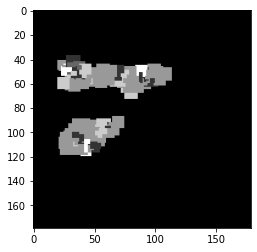

In [ ]:
doplt(ss_map[N//2])

## save data

In [6]:
wdir = '/content/drive/My Drive/mbp/3DCNN_sspred/synthetic_data_202011/'
# fname = wdir+pdbid+'_ss_map'
# np.save(fname,ss_map)
# fname = wdir+pdbid+'_syn_map'
# np.save(fname,synthetic_map)

In [9]:
%ls /content/drive/My\ Drive/mbp/3DCNN_sspred/synthetic_data_202011/

3j5p_ss_map.npy  3j5p_syn_map.npy


# load data

In [6]:
wdir = '/content/drive/My Drive/mbp/3DCNN_sspred/synthetic_data_202011/'

fname = '3j5p_ss_map.npy'
ss_map = np.load(wdir+fname)
ss_map.shape

(179, 179, 179)

In [7]:
fname = '3j5p_syn_map.npy'
synthetic_map = np.load(wdir+fname)
synthetic_map.shape

(179, 179, 179)

# 3D Conv
https://towardsdatascience.com/step-by-step-implementation-3d-convolutional-neural-network-in-keras-12efbdd7b130

## split into pieces 
* Haruspex used 576 structures, 2183 segments of size $70^3$ voxels
* with 100 (small) maps, and on average 20 segents/map, we get 2k segments. At  $25^3$ voxels / segment that is $(20*25^3)^3\sim 67.8^3$ voxels / map, which shows that the segments can be larger.


In [8]:
N=ss_map.shape[0]


In [9]:
seg_size = 32
sample_shape = (seg_size,seg_size,seg_size,1)
X = np.zeros(((N//seg_size)**3,)+sample_shape,dtype=synthetic_map.dtype)
X.shape

(125, 32, 32, 32, 1)

In [11]:
targets = np.zeros(X.shape, dtype=ss_map.dtype)
targets.shape

(125, 32, 32, 32, 1)

In [12]:
record=0
for i in range(0,N-seg_size,seg_size):
  for j in range(0,N-seg_size,seg_size):
    for k in range(0,N-seg_size,seg_size):
      X[record,:,:,:,0] = synthetic_map[i:i+seg_size,j:j+seg_size,k:k+seg_size]
      targets[record,:,:,:,0] = ss_map[i:i+seg_size,j:j+seg_size,k:k+seg_size]
      record += 1
      

In [13]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   #if like me you do not have a lot of memory in your GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "" #then these two lines force keras to use your CPU
import keras

from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout, BatchNormalization
from keras.utils import to_categorical

In [14]:
ind_rand = np.arange(X.shape[0])
np.random.seed(0)
np.random.shuffle(ind_rand)
X = X[ind_rand]

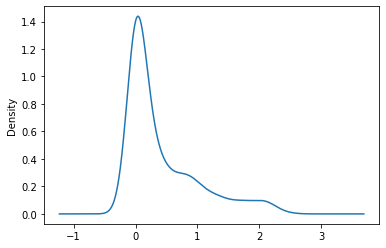

In [15]:
# add in noise to prevent nans
pd.Series(X[~np.isclose(X,0)]).sample(frac=0.001).plot.kde()

In [16]:
noise = 0.01
X += np.random.normal(loc=np.zeros_like(X),scale=noise)


In [17]:
split_i = int(0.7*X.shape[0])
X_train, X_test = X[:split_i], X[split_i:]
targets_train, targets_test = to_categorical(targets[:split_i]), to_categorical(targets[split_i:])

In [18]:
pd.Series(targets[:split_i].flatten()).value_counts()

0    2663991
3      84297
2      36037
1      30482
4      20902
5      12144
7       1771
6       1192
dtype: int64

In [19]:
targets_train.reshape(-1,8).sum(0)

array([2.663991e+06, 3.048200e+04, 3.603700e+04, 8.429700e+04,
       2.090200e+04, 1.214400e+04, 1.192000e+03, 1.771000e+03],
      dtype=float32)

## Model architecture

In [20]:
import keras
from keras.models import Sequential
from keras.layers import Input, concatenate, UpSampling3D, Dense, Flatten, Conv3D, MaxPooling3D, Dropout, BatchNormalization
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

In [21]:
img_input = Input(shape=(seg_size,seg_size,seg_size,1 ))

conv1 = Conv3D(32, (3, 3,3), activation='relu', padding='same')(img_input)
conv1 = Dropout(0.2)(conv1)
conv1 = Conv3D(32, (3, 3,3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling3D((2, 2,2))(conv1)

conv2 = Conv3D(64, (3, 3,3), activation='relu', padding='same')(pool1)
conv2 = Dropout(0.2)(conv2)
conv2 = Conv3D(64, (3, 3,3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling3D((2, 2,2))(conv2) 

conv3 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(pool2)
conv3 = Dropout(0.2)(conv3)
conv3 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(conv3)

up1 = concatenate([UpSampling3D((2, 2,2))(conv3), conv2], axis=-1)
conv4 = Conv3D(64, (3, 3,3), activation='relu', padding='same')(up1)
conv4 = Dropout(0.2)(conv4)
conv4 = Conv3D(64, (3, 3,3), activation='relu', padding='same')(conv4)

up2 = concatenate([UpSampling3D((2, 2,2))(conv4), conv1], axis=-1)
conv5 = Conv3D(32, (3, 3,3), activation='relu', padding='same')(up2)
conv5 = Dropout(0.2)(conv5)
conv5 = Conv3D(32, (3, 3,3), activation='relu', padding='same')(conv5)

n_classes = targets_train.shape[-1]
out = Conv3D( n_classes, (1, 1,1) , padding='same')(conv5)

## compile

In [75]:
model = keras.Model(img_input, out, name="3dcnn")
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(lr=0.001),
              metrics=['accuracy'],
              sample_weight_mode="temporal"
              )
model.summary()


Model: "3dcnn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 32,  0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 32, 32, 32, 3 896         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 32, 32, 32, 3 0           conv3d[0][0]                     
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 32, 32, 32, 3 27680       dropout[0][0]                    
______________________________________________________________________________________________

## balance classes
* https://github.com/keras-team/keras/issues/3653
  * https://github.com/keras-team/keras/issues/3653#issuecomment-564478335
  * https://github.com/keras-team/keras/issues/3653#issuecomment-312231324
    * https://medium.com/@First350/tensorflow-dealing-with-imbalanced-data-eb0108b10701
  * https://github.com/keras-team/keras/issues/3653#issuecomment-557844450
    * TODO: ignore empty

In [52]:
#not_mask_idx = targets_train.reshape(-1,8).argmax(1) != 0


In [78]:
#freqs = targets_train.reshape(-1,8)[not_mask_idx].sum(0)
freqs = targets_train.reshape(-1,8).sum(0)
reweight = np.median(freqs)/freqs
#reweight[0] = 0
reweight

array([9.6441768e-03, 8.4285808e-01, 7.1293396e-01, 3.0477953e-01,
       1.2291647e+00, 2.1156127e+00, 2.1553692e+01, 1.4507058e+01],
      dtype=float32)

In [79]:
pd.Series((targets_train.reshape(-1,8)*reweight).sum(-1).flatten()).value_counts()

0.009644     2663991
0.304780       84297
0.712934       36037
0.842858       30482
1.229165       20902
2.115613       12144
14.507058       1771
21.553692       1192
dtype: int64

In [80]:
targets_train_balanced = (targets_train.reshape(-1,8)*reweight).reshape(targets_train.shape)
targets_train_balanced.shape

(87, 32, 32, 32, 8)

In [81]:

sample_weights = np.squeeze(np.sum(targets_train_balanced, axis=-1))
sample_weights.shape

(87, 32, 32, 32)

## fit

In [82]:
# Fit data to model
history = model.fit(X_train, targets_train, 
                    sample_weight=sample_weights,
            batch_size=20,
            epochs=10,
            verbose=1,
            validation_split=0.3)

Epoch 1/10
3/3 [==============================] - 1s 226ms/step - loss: 9.5486e-09 - accuracy: 0.9349 - val_loss: 6.4749e-09 - val_accuracy: 0.9335
Epoch 2/10
3/3 [==============================] - 0s 161ms/step - loss: 9.5486e-09 - accuracy: 0.9349 - val_loss: 6.4749e-09 - val_accuracy: 0.9335
Epoch 3/10
3/3 [==============================] - 0s 160ms/step - loss: 9.5486e-09 - accuracy: 0.9349 - val_loss: 6.4749e-09 - val_accuracy: 0.9335
Epoch 4/10
3/3 [==============================] - 0s 159ms/step - loss: 9.5486e-09 - accuracy: 0.9349 - val_loss: 6.4749e-09 - val_accuracy: 0.9335
Epoch 5/10
3/3 [==============================] - 0s 162ms/step - loss: 9.5486e-09 - accuracy: 0.9349 - val_loss: 6.4749e-09 - val_accuracy: 0.9335
Epoch 6/10
3/3 [==============================] - 0s 161ms/step - loss: 9.5486e-09 - accuracy: 0.9349 - val_loss: 6.4749e-09 - val_accuracy: 0.9335
Epoch 7/10
3/3 [==============================] - 0s 162ms/step - loss: 9.5486e-09 - accuracy: 0.9349 - val_loss

In [83]:
n_sub=X_train.shape[0]
predict_train = model.predict(X_train[:n_sub])
predict_train.reshape(-1,8).argmax(1).shape, targets_train[:n_sub].reshape(-1,8).argmax(1).shape
pd.Series(predict_train.reshape(-1,8).argmax(1)).value_counts()


0    2850816
dtype: int64

In [85]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(predict_train.reshape(-1,8).argmax(1), targets_train[:n_sub].reshape(-1,8).argmax(1))
cm

array([[2663991,   30482,   36037,   84297,   20902,   12144,    1192,
           1771],
       [      0,       0,       0,       0,       0,       0,       0,
              0],
       [      0,       0,       0,       0,       0,       0,       0,
              0],
       [      0,       0,       0,       0,       0,       0,       0,
              0],
       [      0,       0,       0,       0,       0,       0,       0,
              0],
       [      0,       0,       0,       0,       0,       0,       0,
              0],
       [      0,       0,       0,       0,       0,       0,       0,
              0],
       [      0,       0,       0,       0,       0,       0,       0,
              0]])

Despite re-weighting the class imbalance, everthing is still getting predicted as the "empty" class.

# scratch

In [ ]:
# Fit data to model
model = keras.Model(img_input, out, name="3dcnn")
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(lr=0.001),
              metrics=['accuracy'],
              )
history = model.fit(X_train, targets_train_balanced, 
            batch_size=20,
            epochs=10,
            verbose=1,
            validation_split=0.3)

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(predict_train.reshape(-1,8)[not_mask_idx].argmax(1), targets_train[:n_sub].reshape(-1,8)[not_mask_idx].argmax(1))
cm